# Introduction

![](https://api.wbez.org/v2/images/0b4638ba-3d65-4026-ae10-e8cf9b7fff27.jpg?width=1600&height=0&mode=ASPECT_WIDTH)

In this notebook, we shall conduct a attempt at topic modelling this CPDP Dataset. 


In [22]:
!pip install -U pyLDAvis

In [1]:
import numpy as np
import pandas as pd 
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
import re
from pprint import pprint
import base64
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import psycopg2
from collections import Counter
from imageio import imread
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import nltk
from sklearn.metrics import classification_report
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import*
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#!python3 -m spacy download en_core_web_sm
#!pip install -U pyLDAvis

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning:

The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#postgre connection and retrieval 
conn = psycopg2.connect("dbname = 'postgres' user = 'cpdbstudent' host = 'codd01.research.northwestern.edu' password = 'DataSci4AI'")
cur = conn.cursor()
query = """
    select crid, summary || cr_text
    from data_allegation
    where summary <> '' OR (cr_text <>'' AND CR_TEXT IS NOT NULL )"""
outputquery = "COPY ({0}) TO STDOUT WITH CSV HEADER".format(query)
with open('data_allegation.csv', 'w') as f:
    cur.copy_expert(outputquery, f)

In [4]:
# Loading in the training data with Pandas
train = pd.read_csv("data_allegation.csv")

# EDA of the CPDB data



In [6]:
train.tail(4)

,crid,?column?
12388,1026051,NaN
12389,1026190,NaN
12390,1026207,NaN
12391,1026439,NaN


In [7]:
train.shape

(12392, 2)

In [8]:
#renaming the columns
train.columns = ['crid', 'summary']
train.tail(1)

,crid,summary
12391,1026439,NaN


### Counting the number of rows with missing value


In [9]:
#missing value columns
train['summary'].isna().sum()

1130

In [10]:
#removing the missing values
train=train.dropna()

In [11]:
train.shape

(11262, 2)

In [12]:
#filter the record by fire-arm related keyword
train=train[train['summary'].str.contains('firearm|gun|fire-arm|shot|shooting|shoot|injured|fire arm|weapon|physical violence')]

In [13]:
train.shape

(575, 2)

In [14]:
cpdp_text = train["summary"].values

#### Finally plotting the word clouds:

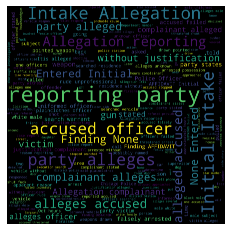

In [15]:
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=4500,
                          height=4500
                         ).generate(" ".join(cpdp_text))
plt.imshow(cloud)
plt.axis('off')
plt.show()

### Analysis
We can see from these word clouds some of the choice words that were favoured by the firearm cases file 
For example, you can see words like "handcuffed", "searched", "arrested","gun" , "hospital" which seem to resonate with our theme of "who fired first?"

In [16]:
#convert to list and Remove new line characters
data = train.summary.values.tolist()
data = [re.sub('\n+', ' ', sent) for sent in data]

In [17]:
pprint(data[15])

('Initial / Intake Allegation 1: The reporting party alleges that the accused '
 'officer was rude and unprofessional in that he called him a "Nigger" The '
 'reporting party alleges that the accused officers were rude and '
 'unprofessional in that they called him a "Nigger". Initial / Intake '
 'Allegation 1: The reporting party alleges that the accused officers were '
 'rude and unprofessional in that they called him a "Nigger” The reporting '
 'party alleges that the accused officer was rude and unprofessional in that '
 'he called him a "Nigger". Allegation 3: Itis alleged that on 06 October '
 '2011, at approximately 2358 hours, in the the vicinity of during a traffic '
 'stop, Officer Rodriguez, pointed a weapon in s direction without '
 'justification stated words to the effect of, Put your fucking hands up,” '
 '“turn the fucking car off," “fuck your license," " get the fuck out of the '
 'car," "shut the fuck up," "get the fuck back," "get the fuck out the '
 'street," "you l

In [18]:
#tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['initial', 'intake', 'allegation', 'it', 'is', 'alleged', 'that', 'the', 'accused', 'was', 'inattentive', 'to', 'duty', 'in', 'that', 'she', 'failed', 'to', 'properly', 'secure', 'her', 'weapon', 'it', 'is', 'reported', 'that', 'the', 'accused', 'went', 'into', 'fitting', 'room', 'at', 'carson', 'pirie', 'scott', 'and', 'left', 'her', 'duty', 'weapon', 'in', 'the', 'fitting', 'room', 'the', 'weapon', 'was', 'recovered', 'by', 'the', 'hammond', 'police', 'department', 'initial', 'intake', 'allegation', 'it', 'is', 'alleged', 'that', 'the', 'accused', 'was', 'inattentive', 'to', 'duty', 'in', 'that', 'she', 'failed', 'to', 'properly', 'secure', 'her', 'weapon', 'it', 'is', 'reported', 'that', 'the', 'accused', 'went', 'into', 'fitting', 'room', 'at', 'carson', 'pirie', 'scott', 'and', 'left', 'her', 'duty', 'weapon', 'in', 'the', 'fitting', 'room', 'the', 'weapon', 'was', 'recovered', 'by', 'the', 'hammond', 'police', 'department', 'finding', 'none', 'entered']]


In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



['initial', 'intake', 'allegation', 'it', 'is', 'alleged', 'that', 'the', 'accused', 'was', 'inattentive', 'to', 'duty', 'in', 'that', 'she', 'failed', 'to', 'properly_secure', 'her', 'weapon', 'it', 'is', 'reported', 'that', 'the', 'accused', 'went', 'into', 'fitting', 'room', 'at', 'carson', 'pirie', 'scott', 'and', 'left', 'her', 'duty', 'weapon', 'in', 'the', 'fitting', 'room', 'the', 'weapon', 'was', 'recovered', 'by', 'the', 'hammond', 'police', 'department', 'initial', 'intake', 'allegation', 'it', 'is', 'alleged', 'that', 'the', 'accused', 'was', 'inattentive', 'to', 'duty', 'in', 'that', 'she', 'failed', 'to', 'properly_secure', 'her', 'weapon', 'it', 'is', 'reported', 'that', 'the', 'accused', 'went', 'into', 'fitting', 'room', 'at', 'carson', 'pirie', 'scott', 'and', 'left', 'her', 'duty', 'weapon', 'in', 'the', 'fitting', 'room', 'the', 'weapon', 'was', 'recovered', 'by', 'the', 'hammond', 'police', 'department', 'finding', 'none', 'entered']


In [20]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:
# Remove Stop Words, Form Bigrams, Initialize spacy 'en' model, keeping only tagger component (for efficiency)
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
CustomListofWordstoExclude = ['report', 'accuse', 'allege', 'party', 'allegation','officer','accuse','initial','intake',"alleg", "accus", "offic", "chicago", "parti", "report","complain", "polic"] 
stop_words.extend(CustomListofWordstoExclude)
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = remove_stopwords(data_lemmatized)
print(data_lemmatized[:1])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning:

SelectableGroups dict interface is deprecated. Use select.

/usr/local/lib/python3.7/dist-pack

[['inattentive', 'duty', 'fail', 'weapon', 'go', 'fitting', 'leave', 'duty', 'weapon', 'fitting', 'room', 'weapon', 'recover', 'police', 'department', 'inattentive', 'duty', 'fail', 'weapon', 'go', 'fitting', 'leave', 'duty', 'weapon', 'fitting', 'room', 'weapon', 'recover', 'department', 'find', 'none', 'enter']]


In [22]:
#The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:2])
# Filter out words that occur less than 20 documents, or more than 50% of the documents.


In [23]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                     id2word=id2word, 
                     num_topics=4,
    
                     random_state=100,
                chunksize=200, passes=100)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning:

Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(n

In [24]:
#outpout of the topics and important words in each of the topic
lda_model.print_topics()

[(0,
  '0.043*"search" + 0.039*"complainant" + 0.032*"enter" + 0.031*"justification" + 0.031*"arrest" + 0.026*"weapon" + 0.024*"gun" + 0.023*"find" + 0.021*"residence" + 0.021*"victim"'),
 (1,
  '0.054*"weapon" + 0.022*"fail" + 0.020*"duty" + 0.016*"find" + 0.013*"itis" + 0.012*"police" + 0.011*"secure" + 0.011*"vehicle" + 0.011*"handcuff" + 0.011*"hour"'),
 (2,
  '0.075*"reporting" + 0.033*"state" + 0.027*"victim" + 0.019*"fail" + 0.017*"arrest" + 0.017*"male" + 0.016*"police" + 0.013*"white" + 0.013*"go" + 0.012*"offender"'),
 (3,
  '0.036*"complainant" + 0.034*"vehicle" + 0.024*"police" + 0.021*"state" + 0.019*"find" + 0.019*"gun" + 0.017*"enter" + 0.017*"none" + 0.015*"reporting" + 0.015*"call"')]

In [25]:
#finding the relevant keywords in each of the document 
def get_document_topic_table(lda_model, corpus, texts=data) :
    # Init output
    document_topic_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(lda_model[corpus]):           
        row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
        topic_num=row[0][0]
        prop_topic=row[0][1]
        wp = lda_model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        document_topic_df.at[i,'best_topic']=topic_num
        document_topic_df.at[i,'prop_topic']=prop_topic
        document_topic_df.at[i,'topic_keywords']=topic_keywords
        document_topic_df.at[i,'document_num']=i
    return document_topic_df
    
document_topic_df = get_document_topic_table(lda_model=lda_model, corpus=corpus, texts=texts)
document_topic_df.head(5)

,best_topic,prop_topic,topic_keywords,document_num
0,1.0,0.878253,"weapon, fail, duty, find, itis, police, secure...",0.0
1,2.0,0.694254,"reporting, state, victim, fail, arrest, male, ...",1.0
2,2.0,0.993810,"reporting, state, victim, fail, arrest, male, ...",2.0
3,0.0,0.685240,"search, complainant, enter, justification, arr...",3.0
4,3.0,0.559633,"complainant, vehicle, police, state, find, gun...",4.0


In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.128907  0.119481       1        1  36.264017
3      0.098050  0.023490       2        1  26.955436
0      0.012696 -0.205940       3        1  26.666514
1     -0.239654  0.062968       4        1  10.114033, topic_info=              Term        Freq       Total Category  logprob  loglift
13          weapon  434.000000  434.000000  Default  30.0000  30.0000
264         search  382.000000  382.000000  Default  29.0000  29.0000
148    complainant  577.000000  577.000000  Default  28.0000  28.0000
110  justification  296.000000  296.000000  Default  27.0000  27.0000
140         arrest  404.000000  404.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
180           take   16.599262  117.566387   Topic4  -5.1411   0.3336
66            head   14.101402   54.083220   Topic4  -5.3042   0.9470
9             none   19.936142  379.141809   Topic4  -4.9579  -0.6541
2            enter   20.516408  498.911338   Topic4  -4.9292  -0.9000
32           point   15.276264  170.432143   Topic4  -5.2241  -0.1208

[277 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
51        1  0.975055      action
14        1  0.976263  additional
235       1  0.939741   aggravate
409       3  0.994274   apartment
125       1  0.207241    approach
...     ...       ...         ...
364       1  0.971637        wife
266       1  0.955779     witness
266       2  0.037728     witness
298       2  0.939683        word
1121      4  0.903289       wound

[354 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [27]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8782,"weapon, fail, duty, find, itis, police, secure...","[inattentive, duty, fail, weapon, go, fitting,..."
1,1,2.0,0.6943,"reporting, state, victim, fail, arrest, male, ...","[reporting, several, uniformed, plainclothe, r..."
2,2,2.0,0.9938,"reporting, state, victim, fail, arrest, male, ...","[reporting, male, black, uniformed, respond, r..."
3,3,0.0,0.6852,"search, complainant, enter, justification, arr...","[reporting, unknown, male, plant, drug, try, c..."
4,4,3.0,0.5597,"complainant, vehicle, police, state, find, gun...","[reporting, entered, residence, justification,..."
5,5,1.0,0.6531,"weapon, fail, duty, find, itis, police, secure...","[duty, discharge, firearm, victim, justificati..."
6,6,3.0,0.9661,"complainant, vehicle, police, state, find, gun...","[reporting, approach, passenger, side, vehicle..."
7,7,2.0,0.8042,"reporting, state, victim, fail, arrest, male, ...","[victim, enter, ciresiit, case, reporting, off..."
8,8,1.0,0.9710,"weapon, fail, duty, find, itis, police, secure...","[fail, properly_secure, weapon, discover, weap..."
9,9,3.0,0.9928,"complainant, vehicle, police, state, find, gun...","[reporting, partner, hispanic, uniform, possib..."


In [28]:
df_dominant_topic.to_csv('result.csv')

In [29]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9971,"search, complainant, enter, justification, arrest, weapon, gun, find, residence, victim","[enter, search, residence, justification, damage, bedroom, door, write, come, get, falsely, arre..."
1,1.0,0.9920,"weapon, fail, duty, find, itis, police, secure, vehicle, handcuff, hour","[husband, separate, process, divorce, transfer, weapon, improperly, never, sign, form, cpd, unkn..."
2,2.0,0.9968,"reporting, state, victim, fail, arrest, male, police, white, go, offender","[reporting, white, female, several, white, male, plainclothe, falsely, arrest, possession, due, ..."
3,3.0,0.9928,"complainant, vehicle, police, state, find, gun, enter, none, reporting, call","[reporting, partner, hispanic, uniform, possibly, flore, fjll, issue, several, false, traffic, c..."


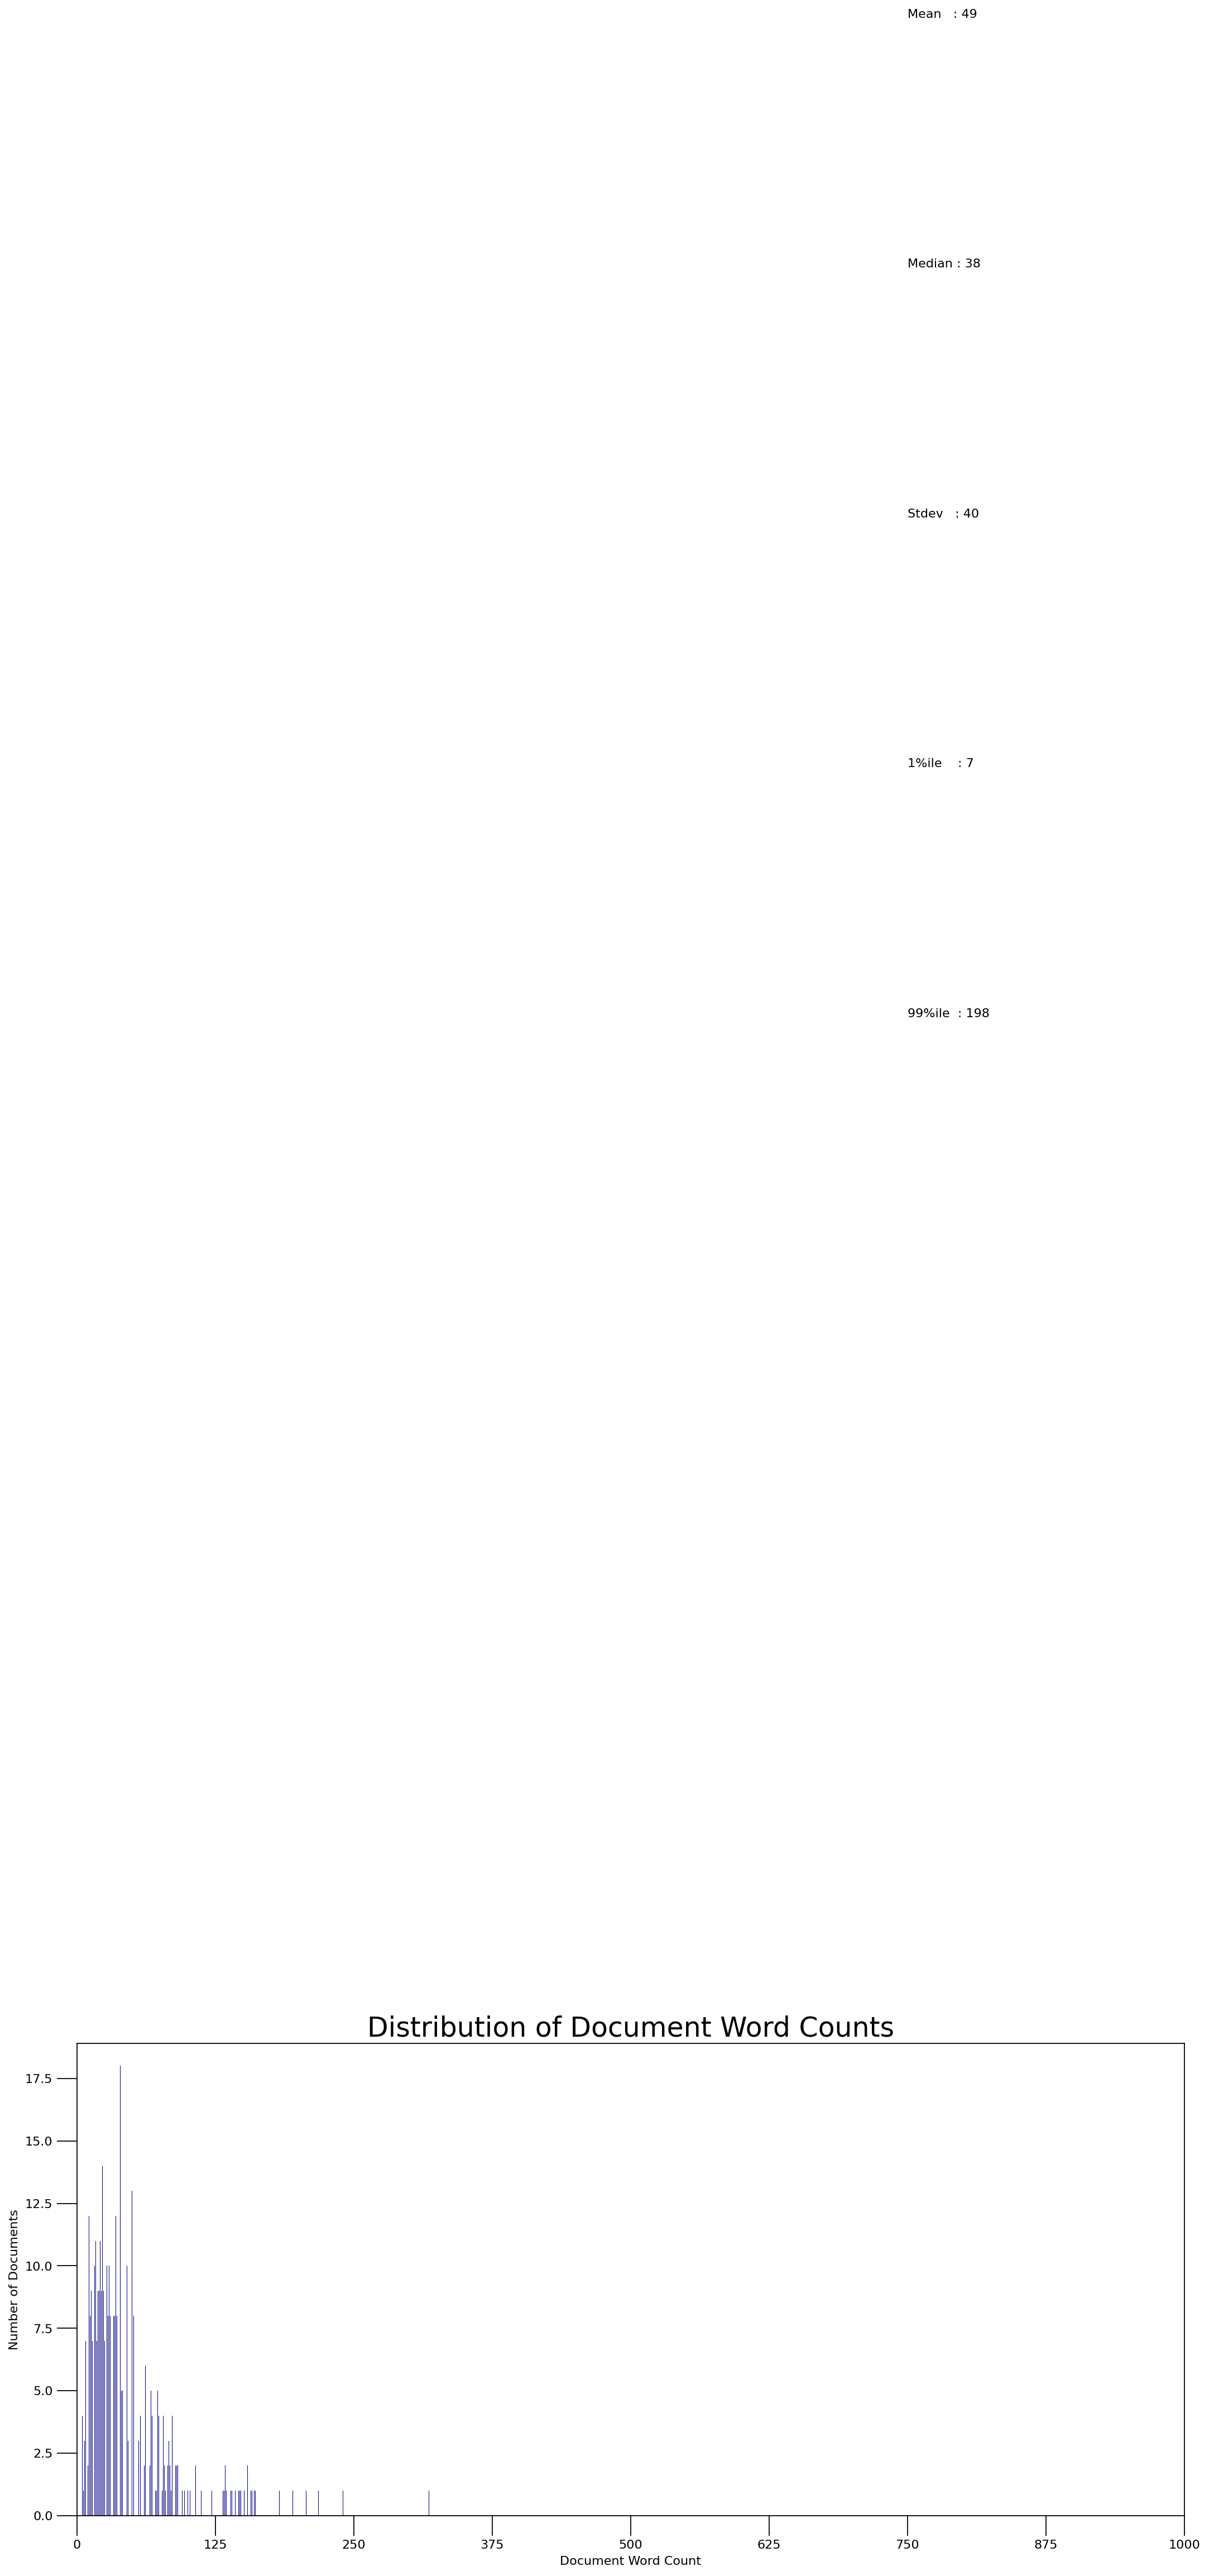

In [30]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()


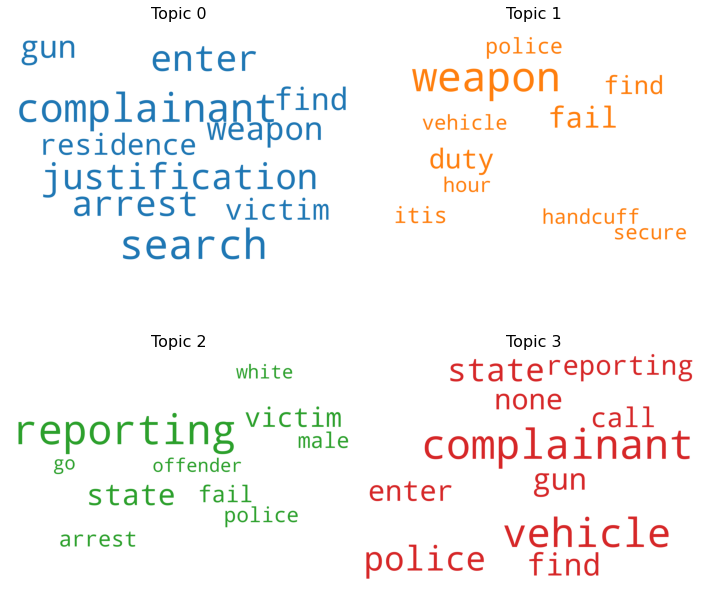

In [31]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


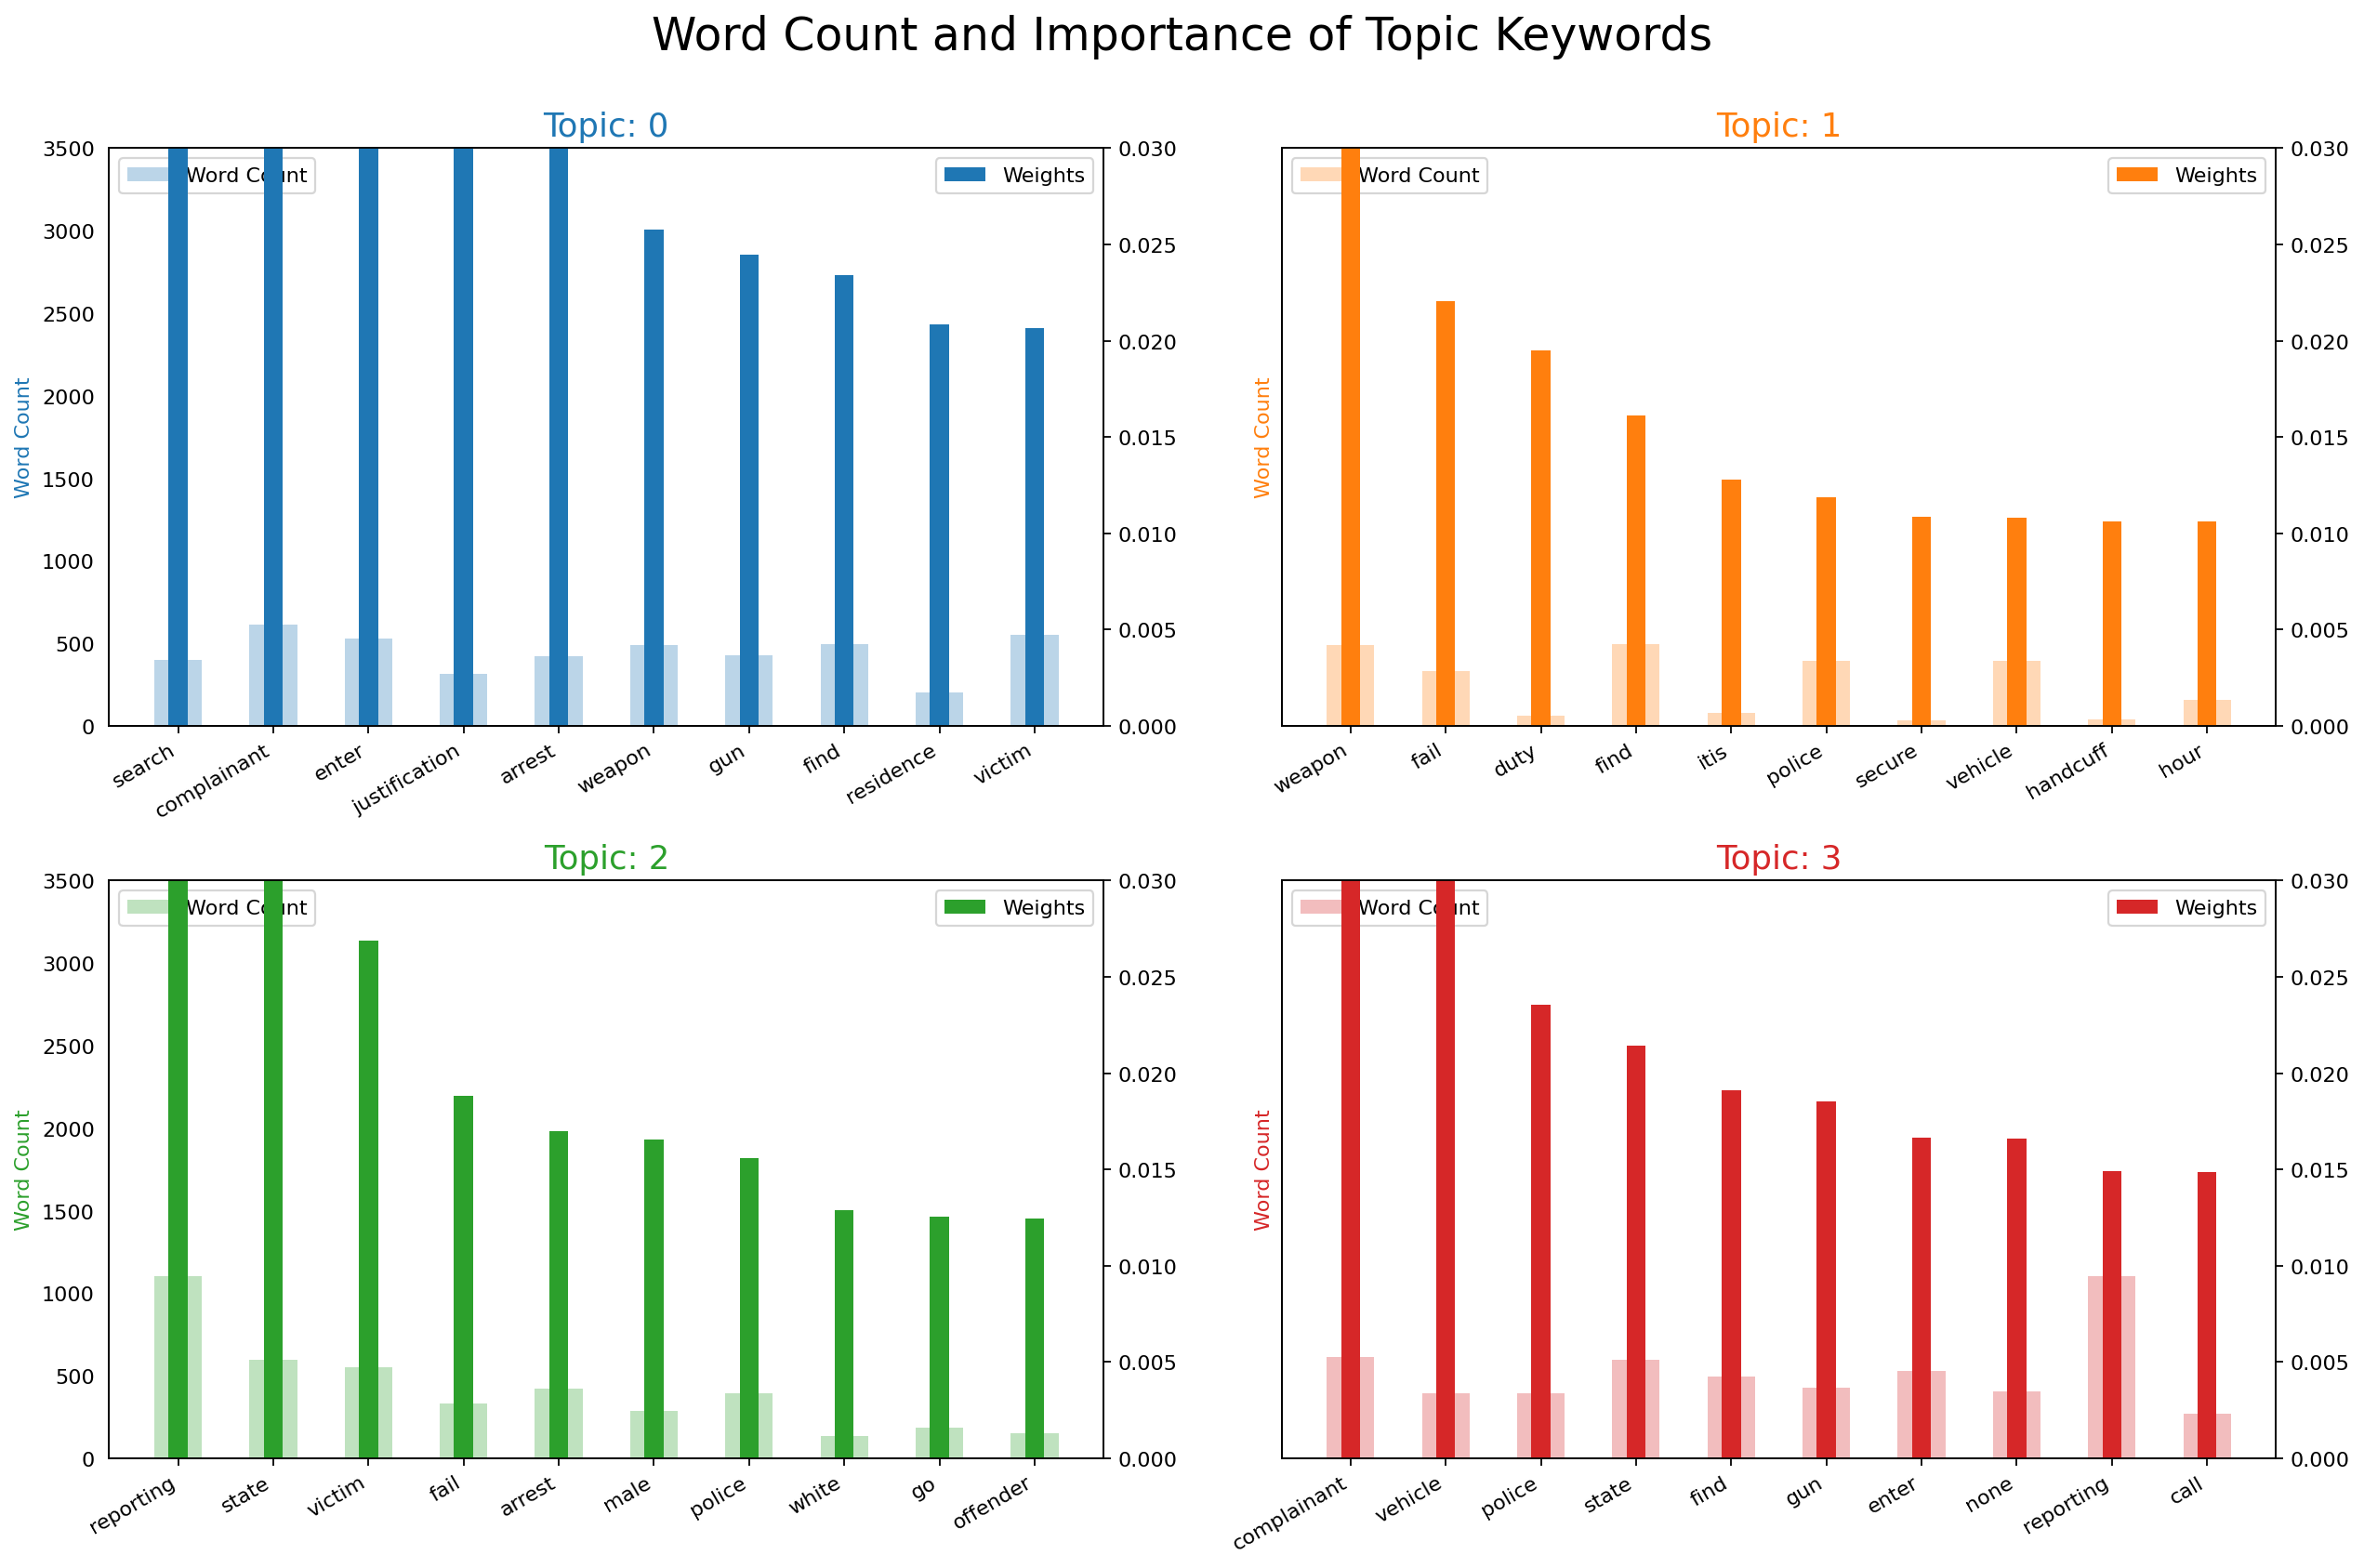

In [32]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


## Sentiment analysis for the "summary" column


In [33]:
senti = SentimentIntensityAnalyzer()
train['summary']=train['summary'].astype(str)


In [34]:
#segregating sentiment analysis into 5 values 
train['Senti_Compound_Score'] = train.summary.apply(lambda x : senti.polarity_scores(x)['compound'])
train['Neutral_score'] = train.summary.apply(lambda x : senti.polarity_scores(x)['neu'])
train['Positive_score'] = train.summary.apply(lambda x : senti.polarity_scores(x)['pos'])
train['Negative_score'] = train.summary.apply(lambda x : senti.polarity_scores(x)['neg'])
train['Caetgory_sentiment']=train['Senti_Compound_Score'] .apply(lambda x:('Strongly Positive' if (1>x>=0.5)  
                                 else('Positive' if  (0.5>x>0) 
                                      else('Neutral' if (x==0)
                                          else('Negative' if (0>x>-0.5) 
                                              else 'Strongly negative')))))

In [35]:
#unique values in sentiment category 
train['Caetgory_sentiment'].unique()

array(['Strongly negative', 'Strongly Positive', 'Negative', 'Positive',
       'Neutral'], dtype=object)

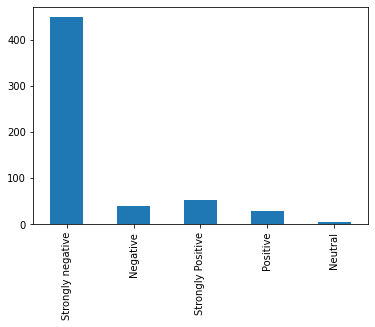

In [36]:
#visualising the distribution of senitment column
train['Caetgory_sentiment'].value_counts().loc[["Strongly negative", "Negative", "Strongly Positive",'Positive','Neutral']].plot(kind="bar")